In [17]:
"""
u_t + (c(x) u)_x = 0 on [a,b]
with u(b) = u(a)
"""

'\nu_t + (c(x) u)_x = 0 on [a,b]\nwith u(b) = u(a)\n'

T = 1
tsteps = 135
    hx = 0.0078125
    ht = 0.00740741
lambda = 0.95


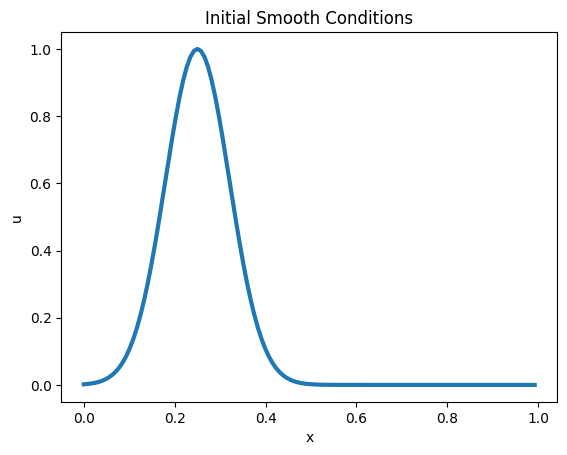

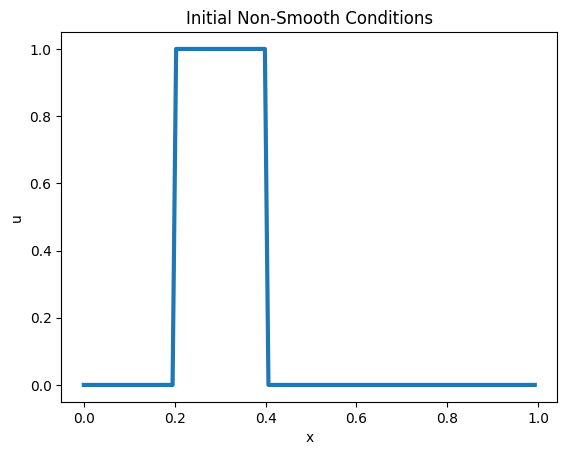

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x):
    u = np.exp(-100 * (x - 0.25)**2)
    return u

def step(x):
    u = np.zeros(x.shape)
    for j in range(len(x)):
        if (x[j] >= 0.2) and (x[j] <= 0.4):
            u[j] = 1.0
    return u

def c(x):
    return 1.0 + 0.0 * x
    #return 2.0 + np.sin(2 * np.pi * x)

#method = 'constant'
method = 'linear'
sigtype = 'LaxW'
#sigtype = 'BW'
#sigtype = 'Fromm'
#sigtype = 'minmod'
#sigtype = 'superbee'

T = 1.0
gamma = 0.95
nx = 128

x, hx = np.linspace(0, 1, nx, endpoint=False, retstep=True)
xx = np.linspace(0, 1-hx, 1000)

ht = hx * gamma / c(x).max()
nt = int(np.ceil(T/ht))
ht = T/nt

print('T = %g' % T)
print('tsteps = %d' % nt)
print('    hx = %g' % hx)
print('    ht = %g' % ht)
print('lambda = %g' % gamma)

J = np.arange(0, nx)  # all vertices
Jm1 = np.roll(J, 1)
Jp1 = np.roll(J, -1)

plt.figure()
plt.plot(x, gaussian(x), '-', linewidth=3)
plt.title("Initial Smooth Conditions")
plt.xlabel("x")
plt.ylabel("u")
plt.show()

plt.figure()
plt.plot(x, step(x), '-', linewidth=3)
plt.title("Initial Non-Smooth Conditions")
plt.xlabel("x")
plt.ylabel("u")
plt.show()


In [10]:

def minmod(a, b):
    c = 0 * a
    for i in range(len(a)):
        if a[i] * b[i] > 0:
            if abs(a[i]) <= abs(b[i]):
                c[i] = a[i]
            else:
                c[i] = b[i]
        else:
            c[i] = 0.0
    return c


TV = []
for n in range(0, nt):

    if method == 'linear':

        if sigtype == 'LaxW':
            sig = (u[Jp1] - u[J]) / hx

        if sigtype == 'minmod':
            sigm = (u[J] - u[Jm1]) / hx
            sigp = (u[Jp1] - u[J]) / hx

            if sigtype == 'minmod':
                sig = minmod(sigm, sigp)

        u[J] = u[J] - (c(x[J]) * ht / hx) * (u[J] - u[Jm1])\
                    - (c(x[J]) * ht / (2.0 * hx)) * (sig[J] - sig[Jm1])\
                                                  * (hx - c(x[J]) * ht)
    uline.set_ydata(u)
    txt.set_text('t=%g, i=%g' % ((n + 1) * ht, n))
    ax.axis([0, 1, -0.25, 1.25])

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.show()
